Upstream aberrations

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({
    'figure.dpi' : 100,
    'image.origin' : 'lower',
    'image.interpolation' : 'nearest',
    'font.size' : 12
})
from matplotlib.colors import LogNorm

from glob import glob
from os import path
import zipfile

import numpy as np
from astropy.io import fits

import hcipy as hp

from itertools import product

# Functions

In [2]:
def forward_model(wf, vvc, fraun, qwp_retardance=90.0, lp_leakage=1e-5, qwpin_angle=45.0, qwpout_angle=45.0, lpin_angle=0, lpout_angle=0, stop_at=None):
    # make polarization optics
    d2r = lambda x: np.deg2rad(x)
    #lpin = hp.LinearPolarizer(d2r(lpin_angle))
    #lpout = hp.LinearPolarizer(d2r(lpout_angle))
    lpin = hp.JonesMatrixOpticalElement(np.asarray([[1,0],[0,lp_leakage]]))
    lpout = hp.JonesMatrixOpticalElement(np.asarray([[1,0],[0,lp_leakage]]))
    qwpin = hp.LinearRetarder(d2r(qwp_retardance), d2r(qwpin_angle))
    qwpout = hp.LinearRetarder(d2r(qwp_retardance), d2r(qwpout_angle))
    
    # through input LP+QWP
    wf_prevvc = qwpin(lpin(wf))
    if stop_at == 'pre-vvc':
        return wf_prevvc
    
    # through VVC
    wf_postvvc = vvc(wf_prevvc)
    if stop_at == 'post-vvc':
        return wf_postvvc

    # through output QWP+LP
    wf_prefp = lpout(qwpout(wf_postvvc))
    wf_fp = fraun(wf_prefp)
    
    return wf_fp

def forward_model2(wf, pupil, lyot_stop, fraun, fraun_final, vvc, qwp1_retardance=90.0, qwp2_retardance=90.0, angle_lpin=0, angle_qwpin=45, angle_qwpout=45, angle_lpout=0, skip_vvc=False, stop_before_vvc=False, stop_at_lyot=False):
    
    d2r = lambda x: np.deg2rad(x)
    # make optics
    #lpin = hp.LinearPolarizer(d2r(angle_lpin)) # need to add 10^-5 leakage
    lpin = hp.JonesMatrixOpticalElement(np.asarray([[1,0],[0,1e-5]]))
    #lpout = hp.LinearPolarizer(d2r(angle_lpout))
    lpout = hp.JonesMatrixOpticalElement(np.asarray([[1,0],[0,1e-5]]))
    qwpin = hp.LinearRetarder(d2r(qwp1_retardance), d2r(angle_qwpin)) #hp.QuarterWavePlate(d2r(angle_qwpin))
    qwpout = hp.LinearRetarder(d2r(qwp2_retardance), d2r(angle_qwpout))#hp.QuarterWavePlate(d2r(angle_qwpout))
    
    # propagate
    wf_prevvc = qwpin(lpin(wf))

    # to VVC focal plane
    wf_focal_prevvc = fraun(wf_prevvc)
    if stop_before_vvc:
        return wf_focal_prevvc
    wf_focal = vvc(wf_focal_prevvc)
    # to pupil
    wf_pupil = lyot_mask(fraun.backward(wf_focal))
    # filter
    wf_postvvc = lpout(qwpout(wf_pupil))
    if stop_at_lyot:
        return wf_postvvc
    
    # to final focal plane
    return fraun_final(wf_postvvc).intensity

def imperfect_circular_polarization(wf, angle_lp, angle_qwp, qwp_retardance):
    
    d2r = lambda x: np.deg2rad(x)
    lp = hp.LinearPolarizer(d2r(angle_lp)) 
    qwp = hp.LinearRetarder(d2r(qwp_retardance), d2r(angle_qwp))
    
    return qwp(lp(wf))

def han2d(shape, yfraction=1./np.sqrt(2), xfraction=1./np.sqrt(2), normalize=False):
    '''
    Radial Hanning window scaled to a fraction 
    of the array size.
    
    Fraction = 1. for circumscribed circle
    Fraction = 1/sqrt(2) for inscribed circle (default)
    '''
    #return np.sqrt(np.outer(np.hanning(shape[0]), np.hanning(shape[0])))

    # scale radial distances
    ymax = shape[0]/2 * yfraction
    xmax = shape[1]/2 * xfraction
    
    y, x = get_yx(shape)
    
    xscaled = (1 - x / xmax) * np.pi/2.
    yscaled = (1 - y / ymax) * np.pi/2.
    
    window = np.sin(xscaled)**2 * np.sin(yscaled)**2
    window[x > (xfraction * x.max())] = 0.
    window[x < (xfraction * x.min())] = 0.
    window[y > (xfraction * y.max())] = 0.
    window[y < (xfraction * y.min())] = 0.
    #window[yscaled > yfraction * yscaled.max()] = 0.
    return window

def get_yx(shape):
    '''
    Compute the radial separation of each pixel
    from the center of a 2D array, and optionally 
    scale in x and y.
    '''
    indices = np.indices(shape)
    cenyx = ( (shape[0] - 1) / 2., (shape[1] - 1)  / 2.)
    return (indices[0] - cenyx[0]), (indices[1] - cenyx[1])

def get_jones_pupils(file_dir):
    
    jxx=fits.getdata(file_dir+'Exxr_R.fits')+1j*fits.getdata(file_dir+'Exxi_R.fits')
    jxy=fits.getdata(file_dir+'Exyr_R.fits')+1j*fits.getdata(file_dir+'Exyi_R.fits')
    jyx=fits.getdata(file_dir+'Eyxr_R.fits')+1j*fits.getdata(file_dir+'Eyxi_R.fits')
    jyy=fits.getdata(file_dir+'Eyyr_R.fits')+1j*fits.getdata(file_dir+'Eyyi_R.fits')
    
    n = jxx.shape[0]
    
    jxxf=jxx.flatten()
    jxyf=jxy.flatten()
    jyxf=jyx.flatten()
    jyyf=jyy.flatten()
    
    #getting rid of the phase wrapping 
    d_phi=np.angle(jxxf*np.conj(jyyf))
    ph_dm=np.angle(jxxf*np.exp(-1j*d_phi))
    
    j_abr_list=[]
    for i in range(len(ph_dm)):
        dm_jones=[[np.exp(-1j*ph_dm[i]),0],
                  [0,np.exp(-1j*ph_dm[i])]]
        jones_mat=[[jxxf[i],jxyf[i]],
                   [jyxf[i],jyyf[i]]]
        j_abr=np.matmul(jones_mat,dm_jones)
        j_abr_list.append(j_abr)


    jxxn_list=[];jxyn_list=[];jyxn_list=[];jyyn_list=[];
    for i in range(len(ph_dm)):
        jxxn=j_abr_list[i][0][0]
        jxyn=j_abr_list[i][0][1]
        jyxn=j_abr_list[i][1][0]
        jyyn=j_abr_list[i][1][1]

        jxxn_list.append(jxxn)
        jxyn_list.append(jxyn)
        jyxn_list.append(jyxn)
        jyyn_list.append(jyyn)

    nx=ny=n;
    jxxn_array=np.reshape(jxxn_list,(nx,ny))
    jxyn_array=np.reshape(jxyn_list,(nx,ny))
    jyxn_array=np.reshape(jyxn_list,(nx,ny))
    jyyn_array=np.reshape(jyyn_list,(nx,ny))

    jdata=[jxxn_array,jxyn_array,jyxn_array,jyyn_array]
    
    return jdata

# Setup

In [3]:
D = 32*0.3e-3 #m
lyot_fraction = 0.9
wavelength = 635e-9
fnum = 48
charge = 6
focal_length = fnum * D
N = 512 #1024
D_dot = 20e-6 # nominal value


# pupils
pupil_grid = hp.make_pupil_grid(N, diameter=D)
pupil = hp.evaluate_supersampled(hp.make_circular_aperture(D), pupil_grid, 16)
lyot_stop = hp.evaluate_supersampled(hp.make_circular_aperture(D*lyot_fraction), pupil_grid, 16)
lyot_mask = hp.Apodizer(lyot_stop)

# brute-force VVC
#q = 20
#focal_grid_vvc = hp.make_focal_grid(q, 200, spatial_resolution=wavelength*fnum, reference_wavelength=wavelength)#, reference_wavelength=wavelength)
#fraun_vvc = hp.FraunhoferPropagator(pupil_grid, focal_grid_vvc, focal_length=fnum*D)

#fast_axis_orientation = hp.Field(charge / 2 * focal_grid_vvc.as_('polar').theta, focal_grid_vvc)
#focal_mask = hp.LinearRetarder(np.deg2rad(180.0), fast_axis_orientation)
#jones_matrix = focal_mask.jones_matrix

#opaque_dot = 1 - hp.evaluate_supersampled(hp.make_circular_aperture(D_dot), focal_grid_vvc, 4)
#vvc0 = hp.JonesMatrixOpticalElement(jones_matrix.reshape((2,2,-1)) * opaque_dot)

# detector
qsmall = 2.5
focal_grid_det = hp.make_focal_grid(qsmall, 20, spatial_resolution=wavelength/D, reference_wavelength=wavelength)#, reference_wavelength=wavelength)
fraun_det = hp.FraunhoferPropagator(pupil_grid, focal_grid_det)

In [4]:
# dh

spat_res = focal_grid_det.regular_coords[0][0]

iwa = 3 * qsmall * spat_res
owa = 10 * qsmall * spat_res
offset = 0 * qsmall * spat_res

dark_zone = hp.make_circular_aperture(2 * owa)(focal_grid_det)
dark_zone -= hp.make_circular_aperture(2 * iwa)(focal_grid_det)
#dark_zone *= focal_grid_det.x > offset
dark_zone = dark_zone.astype(bool)


spat_res = focal_grid_det.regular_coords[0][0]

iwa = 3 * qsmall * spat_res
owa = 4 * qsmall * spat_res
offset = 0 * qsmall * spat_res

dark_zone_34 = hp.make_circular_aperture(2 * owa)(focal_grid_det)
dark_zone_34 -= hp.make_circular_aperture(2 * iwa)(focal_grid_det)
#dark_zone_34 *= focal_grid_det.x > offset
dark_zone_34 = dark_zone_34.astype(bool)

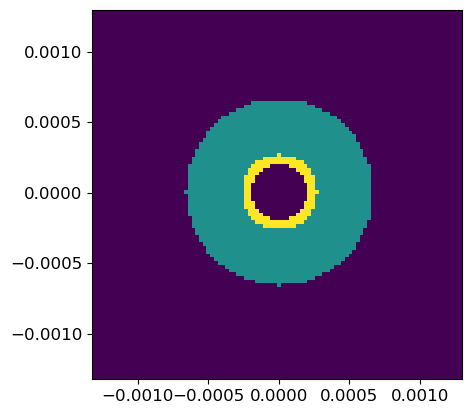

In [5]:
hp.imshow_field(dark_zone+dark_zone_34.astype(float))

jones pupils

In [6]:
jdata = get_jones_pupils('../Polarization-aberrations-ESC/Jones_pupils_2m_upstream/')
#jdata = get_jones_pupils('../Polarization-aberrations-ESC/enhanced_Al/')
#jdata = get_jones_pupils('../Polarization-aberrations-ESC/oa_TMA/bare_Al/')

# Model VVC, Jones Pupils, Imperfect LP+QWPs

perfect case

In [7]:
qwp_retardance = 90.0
vvc_retardance = 180.0 
lp_leakage = 0

vvc = hp.VectorVortexCoronagraph(charge, phase_retardation=np.deg2rad(vvc_retardance), lyot_stop=lyot_stop) 

In [8]:
tilt=1e3
wf = hp.Wavefront(pupil*np.exp(1j*2*np.pi*pupil_grid.x*tilt),
                  input_stokes_vector=[1,0,0,0], wavelength=wavelength)
wfout = forward_model(wf, vvc, fraun_det, qwp_retardance=qwp_retardance, lp_leakage=lp_leakage)

norm = wfout.intensity.max()

6.098809229209027e-13 2.875928689701756e-13


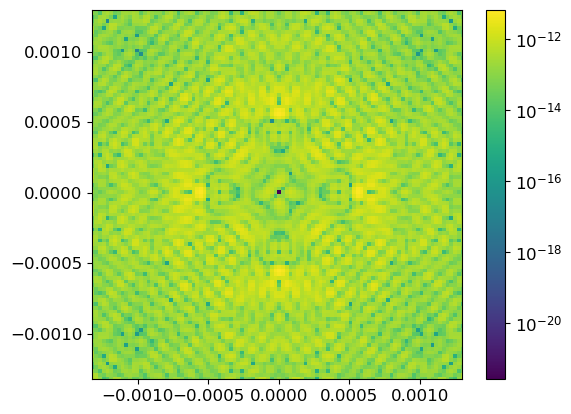

In [9]:
tilt=0
wf = hp.Wavefront(pupil,input_stokes_vector=[1,0,0,0], wavelength=wavelength)
wfout = forward_model(wf, vvc, fraun_det, qwp_retardance=qwp_retardance, lp_leakage=lp_leakage)
contrast = wfout.intensity / norm

hp.imshow_field(contrast, norm=LogNorm())
plt.colorbar()

print(np.mean(contrast[dark_zone]), np.mean(contrast[dark_zone_34]))

Jones pupil aberrations, but no LP, QWP, or VVC errors

In [10]:
qwp_retardance = 90.0
vvc_retardance = 180.0 
lp_leakage = 0

vvc = hp.VectorVortexCoronagraph(charge, phase_retardation=np.deg2rad(vvc_retardance), lyot_stop=lyot_stop) 

In [11]:
tilt=1e3
jdata = np.asarray(jdata)
jdata[np.isnan(jdata)] = 0
jdata_flat = [j.ravel()*np.exp(1j*2*np.pi*pupil_grid.x*tilt) for j in jdata]
wf = hp.Wavefront(pupil*hp.Field([[jdata_flat[0],jdata_flat[1]],[jdata_flat[2],jdata_flat[3]]],pupil_grid),
                  input_stokes_vector=[1,0,0,0], wavelength=wavelength)
wfout = forward_model(wf, vvc, fraun_det, qwp_retardance=qwp_retardance, lp_leakage=lp_leakage)

norm = wfout.intensity.max()

6.105733017447771e-13 2.8835291693078406e-13


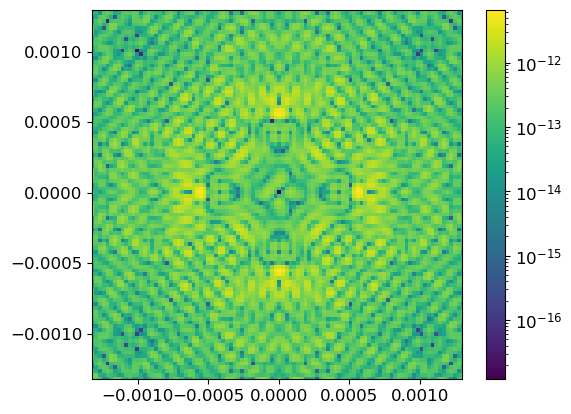

In [12]:
tilt=0
jdata_flat = [j.ravel()*np.exp(1j*2*np.pi*pupil_grid.x*tilt) for j in jdata]
wf = hp.Wavefront(pupil*hp.Field([[jdata_flat[0],jdata_flat[1]],[jdata_flat[2],jdata_flat[3]]],pupil_grid),input_stokes_vector=[1,0,0,0], wavelength=wavelength)
wfout = forward_model(wf, vvc, fraun_det, qwp_retardance=qwp_retardance, lp_leakage=lp_leakage)
contrast = wfout.intensity / norm

hp.imshow_field(contrast, norm=LogNorm())
plt.colorbar()

print(np.mean(contrast[dark_zone]), np.mean(contrast[dark_zone_34]))

No Jones pupil aberrations, but errors on QWPs, LPs, and VVC

In [14]:
# retardance errors on the VVC only matter if you have imperfect extinction through the circular polarizers
qwp_retardance = 92.0
vvc_retardance = 178.0
lp_leakage=1e-5

vvc = hp.VectorVortexCoronagraph(charge, phase_retardation=np.deg2rad(vvc_retardance), lyot_stop=lyot_stop) 

In [15]:
tilt=1e3
wf = hp.Wavefront(pupil*np.exp(1j*2*np.pi*pupil_grid.x*tilt),
                  input_stokes_vector=[1,0,0,0], wavelength=wavelength)
wfout = forward_model(wf, vvc, fraun_det, qwp_retardance=qwp_retardance, lp_leakage=lp_leakage)

norm = wfout.intensity.max()

1.2419175047099328e-10 5.359259885405719e-10


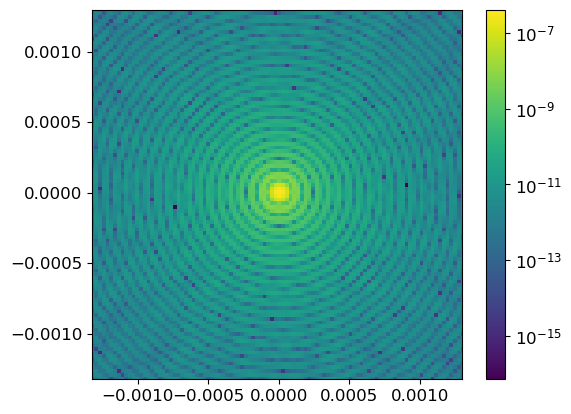

In [17]:
tilt=0
wf = hp.Wavefront(pupil,input_stokes_vector=[1,0,0,0], wavelength=wavelength)
wfout = forward_model(wf, vvc, fraun_det, qwp_retardance=qwp_retardance, lp_leakage=lp_leakage)
contrast = wfout.intensity / norm

hp.imshow_field(contrast, norm=LogNorm())
plt.colorbar()

print(np.mean(contrast[dark_zone]), np.mean(contrast[dark_zone_34]))

Jones pupil aberrations and errors on QWPs, LPs, and VVC

In [18]:
# retardance errors on the VVC only matter if you have imperfect extinction through the circular polarizers
qwp_retardance = 92.0
vvc_retardance = 178.0
lp_leakage=1e-5

vvc = hp.VectorVortexCoronagraph(charge, phase_retardation=np.deg2rad(vvc_retardance), lyot_stop=lyot_stop) 

In [19]:
tilt=1e3
jdata_flat = [j.ravel()*np.exp(1j*2*np.pi*pupil_grid.x*tilt) for j in jdata]
wf = hp.Wavefront(pupil*hp.Field([[jdata_flat[0],jdata_flat[1]],[jdata_flat[2],jdata_flat[3]]],pupil_grid),
                  input_stokes_vector=[1,0,0,0], wavelength=wavelength)
wfout = forward_model(wf, vvc, fraun_det, qwp_retardance=qwp_retardance, lp_leakage=lp_leakage)

norm = wfout.intensity.max()

1.2431374293364453e-10 5.364515933894365e-10


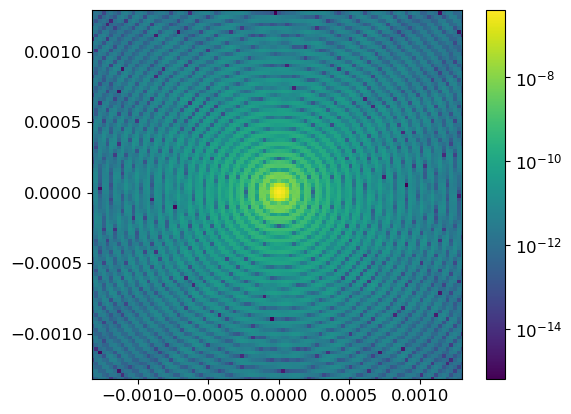

In [20]:
tilt=0
jdata_flat = [j.ravel()*np.exp(1j*2*np.pi*pupil_grid.x*tilt) for j in jdata]
wf = hp.Wavefront(pupil*hp.Field([[jdata_flat[0],jdata_flat[1]],[jdata_flat[2],jdata_flat[3]]],pupil_grid),input_stokes_vector=[1,0,0,0], wavelength=wavelength)
wfout = forward_model(wf, vvc, fraun_det, qwp_retardance=qwp_retardance, lp_leakage=lp_leakage)
contrast = wfout.intensity / norm

hp.imshow_field(contrast, norm=LogNorm())
plt.colorbar()

print(np.mean(contrast[dark_zone]), np.mean(contrast[dark_zone_34]))